### Данные

Решим задачу бинарной классификации, а именно построим алгоритм, определяющий превысит ли средний заработок человека порог $50k

Будем смотреть на показатель Area Under ROC Curve (ROC_AUC).  https://ru.wikipedia.org/wiki/ROC-кривая

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

##### Данные

1) age (Возраст): continuous. 

2) workclass (Информация о работе): Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

3) fnlwgt (Вещественный признак - анонимен): continuous. 

4) education (Образование): Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

5) education-num: continuous. 

6) marital-status (Семейное положение): Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

7) occupation (Род деятельности): Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

8) relationship (Статус в семье): Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

9) race (Раса): White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

10) sex (Пол): Female, Male. 

11) capital-gain (Размер капитала): continuous. 

12) capital-loss (Фича на основе капитала): continuous. 

13) hours-per-week (Сколько часов в неделю работает): continuous.

14) >50K,<=50K (Таргет)

##### Загружаем данные

In [2]:
# В данной таблице NaNы заполнены значком '?' - заменим его на проспуски с помощью параметра "na_values"
data_adult = pd.read_csv("data.adult.csv", na_values='?')
data_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


### 1. Анализ

In [3]:
row_num_before = data_adult.shape[0] 
print(row_num_before)
data_adult = data_adult.dropna()
row_num_after = data_adult.shape[0] 
print(row_num_after)

print("Строк стало меньше на ", row_num_before-row_num_after)

16280
15347
Строк стало меньше на  933


In [4]:
target = data_adult['>50K,<=50K']
target = target.replace({'<=50K':0,'>50K':1})
data_adult.drop(columns='>50K,<=50K',inplace=True)
data_adult['target'] = target
target.describe()


count    15347.000000
mean         0.256728
std          0.436842
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: >50K,<=50K, dtype: float64

Процентное соотношение категорий


Private             73.512739
Self-emp-not-inc     8.627093
Local-gov            6.952499
State-gov            4.202776
Self-emp-inc         3.655438
Federal-gov          3.003844
Without-pay          0.045612
Name: workclass, dtype: float64

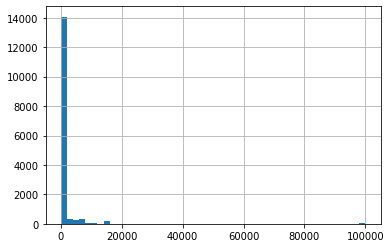

In [5]:
data_adult['capital-gain'].hist(bins=50) 
print("Процентное соотношение категорий")
100 * data_adult['workclass'].value_counts()/data_adult['workclass'].value_counts().sum()

### 2. Категориальные признаки

У нас есть некоторые категориальные признаки.

In [6]:
cat = data_adult.select_dtypes(include='object')

num = data_adult.select_dtypes(include='int64')
target = target
print(data_adult.shape)

(15347, 14)


In [7]:
data_adult = data_adult.join(pd.get_dummies(cat))
print(data_adult)
print(data_adult.shape)
data_adult.drop(columns=cat, inplace=True)

       age  workclass  fnlwgt     education  education-num  \
0       34  Local-gov  284843       HS-grad              9   
1       40    Private  190290  Some-college             10   
2       36  Local-gov  177858     Bachelors             13   
3       22    Private  184756  Some-college             10   
4       47    Private  149700     Bachelors             13   
...    ...        ...     ...           ...            ...   
16275   25  Local-gov  514716     Bachelors             13   
16276   32    Private  207668     Bachelors             13   
16277   27    Private  104457     Bachelors             13   
16278   59  State-gov  268700       HS-grad              9   
16279   33    Private   59083     Bachelors             13   

           marital-status         occupation   relationship  \
0           Never-married    Farming-fishing  Not-in-family   
1                Divorced              Sales  Not-in-family   
2      Married-civ-spouse     Prof-specialty      Own-child   
3  

In [8]:
train_columns = data_adult.columns.difference(['target'])
print(train_columns)

Index(['age', 'capital-gain', 'capital-loss', 'education-num',
       'education_10th', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'fnlwgt', 'hours-per-week',
       'marital-status_Divorced', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'o

### 3. Нормализация данных

In [9]:
print("mean values:\n",num.mean())
print("min values:\n",num.min())
print("max values:\n",num.max())

mean values:
 age                   38.495537
fnlwgt            189154.533915
education-num         10.150844
capital-gain        1053.294129
capital-loss          88.667492
hours-per-week        40.892422
target                 0.256728
dtype: float64
min values:
 age                  17
fnlwgt            19302
education-num         1
capital-gain          0
capital-loss          0
hours-per-week        1
target                0
dtype: int64
max values:
 age                    90
fnlwgt            1484705
education-num          16
capital-gain        99999
capital-loss         3900
hours-per-week         99
target                  1
dtype: int64


* Использование данных разного масшаба может часто приводить к тому, что обучающая модель будет строить неверные зависимости.  
*  Влияет, например, на линейную регрессию, svm, knn, поскольку там используется расстояние между точками, которое будет разное при разном масштабе данных, следовательно, будети разный результат

Масштабируем данные

In [10]:
from sklearn.preprocessing import StandardScaler
data_adult['target'] = target
scaler = StandardScaler()
scaler.fit(data_adult)
X = data_adult[train_columns]
y = target
print(X.shape)
print(y.shape)

(15347, 63)
(15347,)


Далее используем масштабированные признаки

### 4. Валидация

В нашем случае будем валидироваться с помощью KFold + сохранение баланса классов в каждом "фолде" с помощью StratifiedKFold из sklearn.model_selection

### 5. Выбор алгоритма и оптимизация

Выберем 3 алгоритма:

 - kNN http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
 - SGD Linear Classifier http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
 - RandomForest http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 5.1 kNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score,cross_validate
from sklearn.metrics import roc_auc_score

In [12]:
knn = KNeighborsClassifier()
parametrs = {
    'n_neighbors':[1, 50],
    'metric':['minkowski', 'euclidean', 'chebyshev', 'manhattan']
}
knn_clf = GridSearchCV(knn,parametrs)
knn_clf.fit(X,y)
print(knn_clf.best_estimator_)
print(knn_clf.best_params_)

KNeighborsClassifier(metric='chebyshev', n_neighbors=50)
{'metric': 'chebyshev', 'n_neighbors': 50}


### Зависимость от метрики

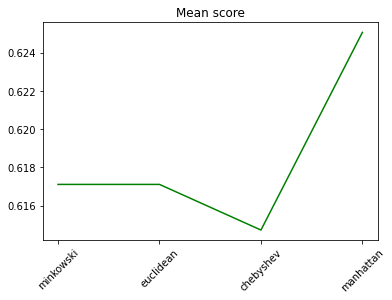

In [13]:
import pylab as pl

y_mean_score = []
y_std_score = []

xTicks = ['minkowski', 'euclidean', 'chebyshev', 'manhattan']
for curr_metric in xTicks:
    knn = KNeighborsClassifier(n_neighbors=50, metric=curr_metric)
    cv_res = cross_validate(knn,X,y, scoring='roc_auc')    #здесь и далее StratifiedKFold используется по умолчанию, поэтому явно не указываем
    y_mean_score.append(cv_res['test_score'].mean())
    y_std_score.append(cv_res['test_score'].std())
x_SGD = y_mean_score
pl.xticks(range(0,4), xTicks, rotation=45)
pl.title("Mean score")
pl.plot(x_SGD, color='green')   
pl.show() 


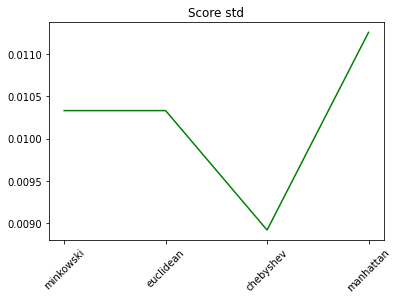

In [14]:
x_SGD = y_std_score

pl.xticks(range(0,4), xTicks, rotation=45)
pl.title("Score std")
pl.plot(x_SGD, color='green')   
pl.show() 

### Зависимость от числа соседей

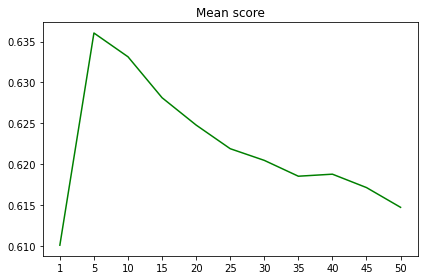

In [15]:
y_mean_score = []
y_std_score = []

xTicks = [1,5,10,15,20,25,30,35,40,45,50]
for neigh_count in xTicks:
    knn = KNeighborsClassifier(n_neighbors=neigh_count, metric='chebyshev',n_jobs=-1)
    cv_res = cross_validate(knn,X,y,scoring='roc_auc')
    y_mean_score.append(cv_res['test_score'].mean())
    y_std_score.append(cv_res['test_score'].std())

x_SGD = y_mean_score
pl.xticks(range(0,len(xTicks)),xTicks)
pl.title("Mean score")
pl.plot(x_SGD, color='green')   
pl.tight_layout()
pl.show() 

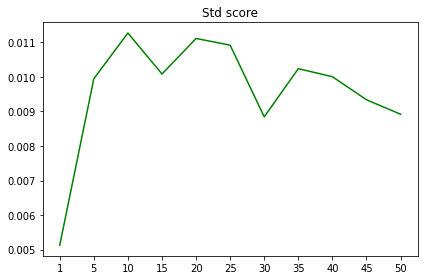

In [16]:
pl.xticks(range(0,len(xTicks)),xTicks)
pl.title("Std score")
pl.plot(y_std_score, color='green')   
pl.tight_layout()
pl.show() 

### 5.2 SGD Linear Classifier

In [17]:
from sklearn.linear_model import SGDClassifier

In [18]:
sgd = SGDClassifier(random_state=0)

parametrs = {
    'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty':['none', 'l2', 'l1', 'elasticnet']
}
sgd_clf = GridSearchCV(sgd,parametrs)
sgd_clf.fit(X,y)
print(sgd_clf.best_estimator_)
print(sgd_clf.best_params_)


c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be 

SGDClassifier(loss='log', penalty='none', random_state=0)
{'loss': 'log', 'penalty': 'none'}


### Зависимомть от loss функции

c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be 

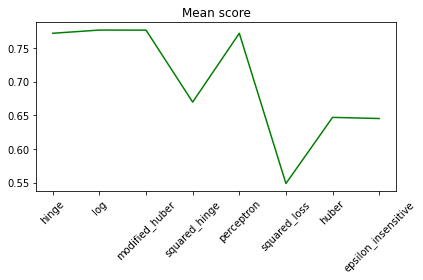

In [19]:
y_mean_score = []
y_std_score = []
xTicks = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive']

for loss_func in xTicks:
    sgd = SGDClassifier(loss = loss_func, penalty='none',random_state=0,n_jobs=-1)
    cv_res = cross_validate(sgd,X,y)
    y_mean_score.append(cv_res['test_score'].mean())
    y_std_score.append(cv_res['test_score'].std())

pl.xticks(range(0,len(xTicks)),xTicks, rotation=45)
pl.title("Mean score")
pl.plot(y_mean_score, color='green')   
pl.tight_layout()
pl.show() 


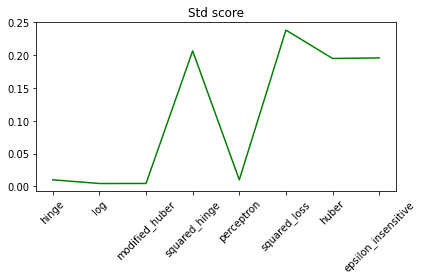

In [20]:
pl.xticks(range(0,len(xTicks)),xTicks, rotation=45)
pl.title("Std score")
pl.plot(y_std_score, color='green')   
pl.tight_layout()
pl.show() 

### Зависимомть от penalty

c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be 

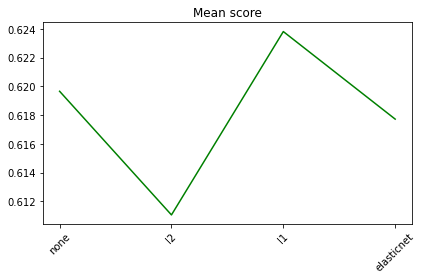

In [21]:
y_mean_score = []
y_std_score = []
xTicks = ['none', 'l2', 'l1', 'elasticnet']

for penalty_type in xTicks:
    sgd = SGDClassifier(loss='log', penalty=penalty_type,random_state=0)
    cv_res = cross_validate(sgd,X,y,scoring='roc_auc')
    y_mean_score.append(cv_res['test_score'].mean())
    y_std_score.append(cv_res['test_score'].std())

pl.xticks(range(0,len(xTicks)),xTicks, rotation=45)
pl.plot(y_mean_score, color='green')
pl.title("Mean score")   
pl.tight_layout()
pl.show() 

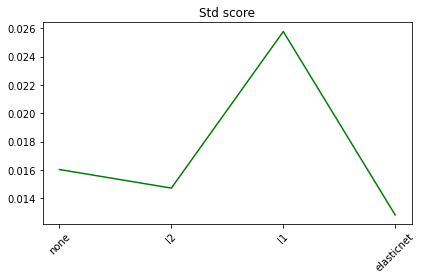

In [22]:
pl.xticks(range(0,len(xTicks)),xTicks, rotation=45)
pl.title("Std score")
pl.plot(y_std_score, color='green')   
pl.tight_layout()
pl.show() 

### 5.3 RandomForestClassifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
max_number_of_estimators = 100

RFC_model = RandomForestClassifier(n_estimators=max_number_of_estimators,random_state=0)
RFC_model.fit(X,y)

rfc_score = cross_validate(RFC_model,X,y,scoring='roc_auc')
rfc_score = rfc_score['test_score'].mean()
res_number = 0


for current_trees_number in range(1,max_number_of_estimators):    
    trees = RFC_model
    trees.estimators_ = RFC_model.estimators_[:current_trees_number]
    trees.n_estimators = current_trees_number


    cv_res = cross_validate(trees,X,y,scoring='roc_auc')
    cv_res = cv_res['test_score'].mean()
    if(abs(rfc_score-cv_res)<0.0001):
        res_number = current_trees_number
        break
    rfc_score = cv_res
print(current_trees_number)

24


####  Grid search

In [25]:
TREES_NUM = 25
rfc = RandomForestClassifier(n_estimators=TREES_NUM,random_state=0)
parametrs = {
    'max_features':['auto', 'sqrt', 'log2', None],
    'criterion':['gini','entropy']
}
rfc_clf = GridSearchCV(rfc,parametrs)
rfc_clf.fit(X,y)
print(rfc_clf.best_estimator_)
print(rfc_clf.best_params_)

c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly 

RandomForestClassifier(max_features=None, n_estimators=25, random_state=0)
{'criterion': 'gini', 'max_features': None}


### Зависимоcть от max_features

c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly 

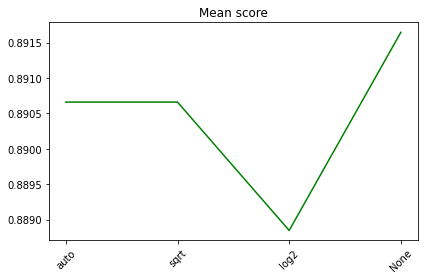

In [26]:
y_mean_score = []
y_std_score = []

xTicks = ['auto', 'sqrt', 'log2', None]

for features in xTicks:
    rfc = RandomForestClassifier(n_estimators=TREES_NUM,max_features = features,criterion='gini',random_state=0)
    cv_res = cross_validate(rfc,X,y,scoring='roc_auc')
    y_mean_score.append(cv_res['test_score'].mean())
    y_std_score.append(cv_res['test_score'].std())


xTicks = ['auto', 'sqrt', 'log2', 'None']
pl.xticks(range(0,len(xTicks)),xTicks, rotation=45)
pl.title("Mean score")
pl.plot(y_mean_score, color='green')   
pl.tight_layout()
pl.show() 

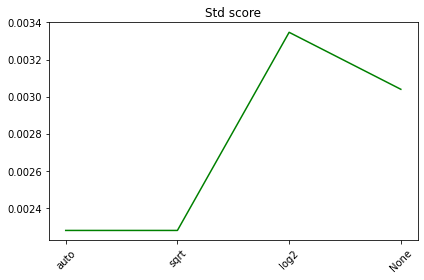

In [27]:
pl.xticks(range(0,len(xTicks)),xTicks, rotation=45)
pl.title("Std score")
pl.plot(y_std_score, color='green')   
pl.tight_layout()
pl.show()

### Зависимоcть от criterion

c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly 

[0.890659549824331, 0.8923143622688974]


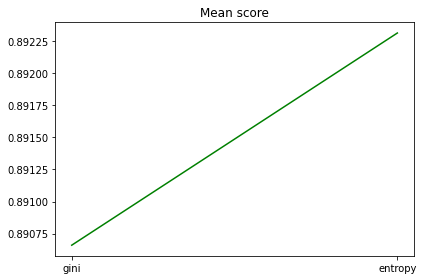

In [28]:
y_mean_score = []
y_std_score = []

xTicks = ['gini','entropy']

for param in xTicks:
    rfc = RandomForestClassifier(n_estimators=TREES_NUM,criterion=param,max_features='auto',random_state=0)
    cv_res = cross_validate(rfc,X,y,scoring='roc_auc')
    y_mean_score.append(cv_res['test_score'].mean())
    y_std_score.append(cv_res['test_score'].std())
    
print(y_mean_score)
pl.xticks(range(0,2),xTicks)
pl.title("Mean score")
pl.plot(y_mean_score, color='green')   
pl.tight_layout()
pl.show() 

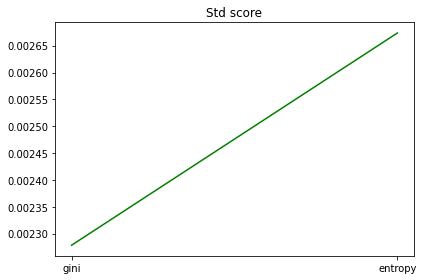

In [29]:
pl.xticks(range(0,len(xTicks)),xTicks)
pl.title("Std score")
pl.plot(y_std_score, color='green')   
pl.tight_layout()
pl.show() 

### 6. Ансамбль моделей

Попробуем различные комбинации алгоритмов. А так же все три алгоритма вместе.

$$result(x) = clf_1(x) * \alpha + clf_2(x) * (1 - \alpha)$$

In [30]:
from sklearn.ensemble import VotingClassifier

In [31]:
classifiers = 3
def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]
voting__weights=combinations_on_off(classifiers)
print(voting__weights)
param_grid = {
    'weights' : voting__weights
}

#for 3 classifiers
knn1 = KNeighborsClassifier(knn_clf.best_params_)
sgd1 = SGDClassifier(sgd_clf.best_params_)
rfc1 = KNeighborsClassifier(rfc_clf.best_params_)

for elem in voting__weights:
    print(elem)
    eclf5 = VotingClassifier(estimators=[
        ('lr', knn1), ('rf', rfc1),('gnb',sgd1)], voting='soft',weights=elem)


[[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
[0, 0, 1]
[0, 1, 0]
[0, 1, 1]
[1, 0, 0]
[1, 0, 1]
[1, 1, 0]
[1, 1, 1]


In [32]:
eclf1 = VotingClassifier(estimators=[
    ('lr', knn), ('rf', rfc),('gnb',sgd)], voting='soft',weights=[0.33,0.34,0.33])


### 7. Ящик с усами

In [33]:
best_model_knn = knn_clf.best_estimator_ 
best_model_random_forest = rfc_clf.best_estimator_  
best_model_sgd = sgd_clf.best_estimator_   
best_model_voting_classifier = eclf1

Посмотрим на наше качество на кросс_валидации:

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
#Используем StratifiedKFold с 7 фолдами
cv_score_knn = cross_val_score(best_model_knn, X, y, cv=7, scoring='roc_auc')
cv_score_random_forest = cross_val_score(best_model_random_forest, X, y, cv=7, scoring='roc_auc')
cv_score_sgd = cross_val_score(best_model_sgd, X, y, cv=7, scoring='roc_auc')
cv_score_voting_classifier = cross_val_score(best_model_voting_classifier, X, y, cv=7, scoring='roc_auc')

c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be 

Создайте таблицу pandas.DataFrame с колонками названиями методо (4 колонки), а значения - выход функции cross_val_score

In [36]:
d = {'knn':cv_score_knn,
    'random_forest':cv_score_random_forest,
    'sgd':cv_score_sgd,
    'voting':cv_score_voting_classifier}
final_result = pd.DataFrame(data=d)


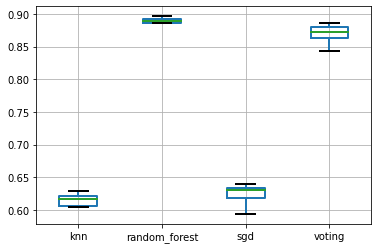

In [37]:
ax = final_result.boxplot() 
_ = plt.setp(ax.lines, linewidth=2.0)
plt.show()

### 8. Выводы

- random_forest показал лучшие результаты по roc_auc
  
- Лучший алгоритм с точки зрения качество/скорость работы:
  * Если не нужно выбирать лучшие параметры, то random forest или knn
- Вкратце плюсы и минусы
  * knn - просота описания, реализации, мало параметров нужно описывать, но плохо работает с категориальными признаками
  * sgd - минус - линейная, очень простая модель, но легкая в реализации
  * random forest - лучше, чем decisionTree, минус - сложно интерпретировать результат 